In [1]:
import numpy as np
import random
import time
import math
import random
import os
import json
import sys
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)
np.random.seed(42)

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *

from model_class.Variety import Variety
from model_class.UD_clan import *

In [2]:
def detect_cycles(G, attribute='clan'):
    """
    Detects cycles in a graph where clans interact through marriage and offspring relationships.
    
    Parameters:
    - G: A networkx DiGraph with nodes containing 'clan', 'mother', and 'children' attributes.
    - attribute: The attribute representing the clan (default: 'clan').
    
    Returns:
    - A dictionary with counts of cycles of length 1 and 2.
    """
    cycle_counts = {"cycle_1": 0, "cycle_2": 0}

    # Iterate over all nodes in the graph
    for node_id, node_data in G.nodes(data=True):
        original_clan = node_data.get(attribute)
        mother_id = node_data.get('mother')

        # If the node has no mother, skip this node
        if not mother_id:
            continue

        # Get the mother's clan
        mother_clan = G.nodes[mother_id].get(attribute) if mother_id in G.nodes else None

        # Check if the mother's clan is the same as the node's clan
        if mother_clan == original_clan:
            # Cycle of 1 (incest)
            cycle_counts["cycle_1"] += 1
            continue

        # Save the mother's clan for further checks
        saved_mother_clan = mother_clan

        # Check the children of the node
        children_ids = node_data.get('children', [])
        for child_id in children_ids:
            if child_id not in G.nodes:
                continue
            
            child_data = G.nodes[child_id]
            child_clan = child_data.get(attribute)
            child_mother_id = child_data.get('mother')

            # If the original node is the mother of this child
            if child_mother_id == node_id:
                # Check if the child's clan matches the saved mother's clan
                if child_clan == saved_mother_clan:
                    # Cycle of 2
                    cycle_counts["cycle_2"] += 1

    return cycle_counts

In [3]:
def detect_cycles_three_generations(G, attribute='clan'):
    """
    Detect cycles of length 2 and 3 in the graph, considering three clans.
    """
    cycle_counts = {"cycle_1": 0, "cycle_2": 0, "cycle_3": 0}

    for node_id, node_data in G.nodes(data=True):
        original_clan = node_data.get(attribute)
        mother_id = node_data.get('mother')

        if not mother_id or mother_id not in G.nodes:
            continue

        mother_clan = G.nodes[mother_id].get(attribute)

        # Cycle of 1 (incest, original node's clan matches its mother's clan)
        if mother_clan == original_clan:
            cycle_counts["cycle_1"] += 1
            continue

        # Cycle of 2: Check daughters
        children_ids = node_data.get('children', [])
        for child_id in children_ids:
            if child_id not in G.nodes:
                continue

            child_data = G.nodes[child_id]
            child_clan = child_data.get(attribute)
            child_mother_id = child_data.get('mother')

            # If the current node is the mother of this child
            if child_mother_id == node_id:
                if child_clan == mother_clan and child_clan != original_clan:
                    cycle_counts["cycle_2"] += 1

                # Cycle of 3: Check granddaughters
                grandchild_ids = child_data.get('children', [])
                for grandchild_id in grandchild_ids:
                    if grandchild_id not in G.nodes:
                        continue

                    grandchild_data = G.nodes[grandchild_id]
                    grandchild_clan = grandchild_data.get(attribute)
                    grandchild_mother_id = grandchild_data.get('mother')

                    # If the child is the mother of this grandchild
                    if grandchild_mother_id == child_id:
                        if grandchild_clan == mother_clan and grandchild_clan != child_clan and grandchild_clan != original_clan:
                            cycle_counts["cycle_3"] += 1

    return cycle_counts

# Dual organization

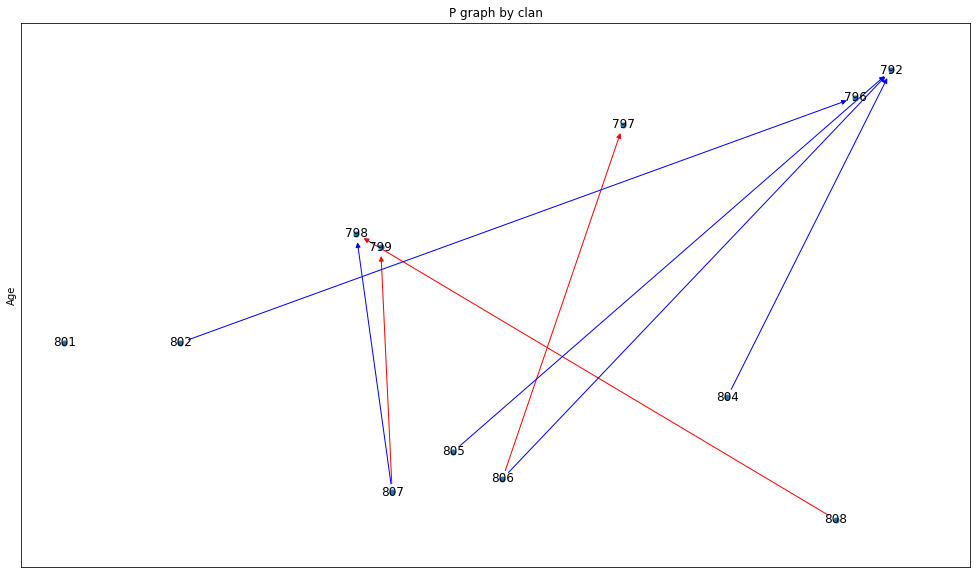

acabo
0


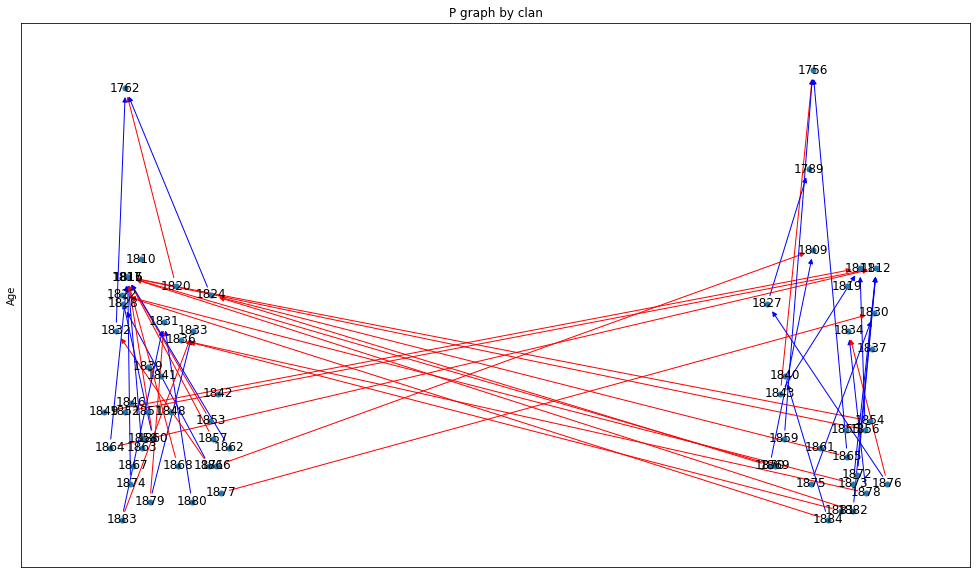

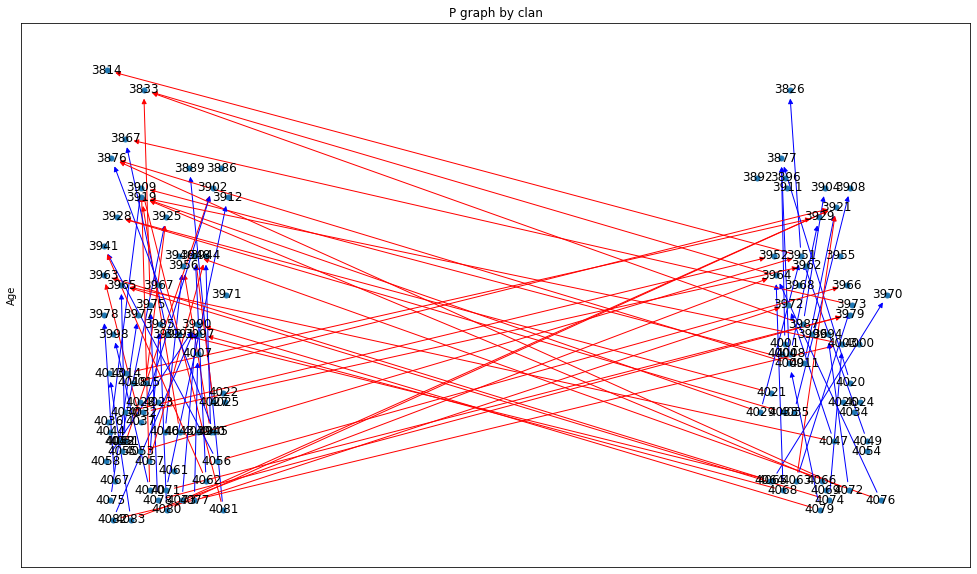

1


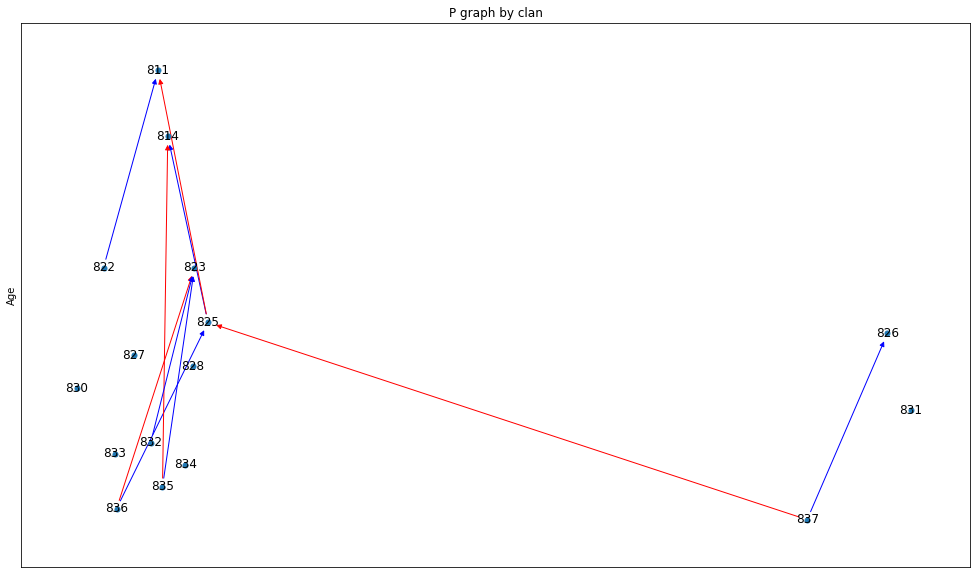

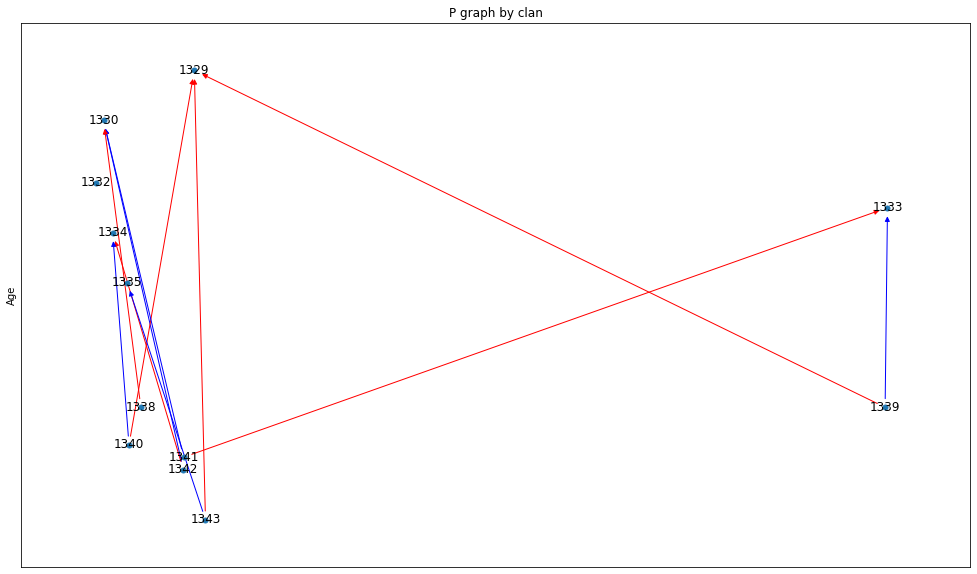

2


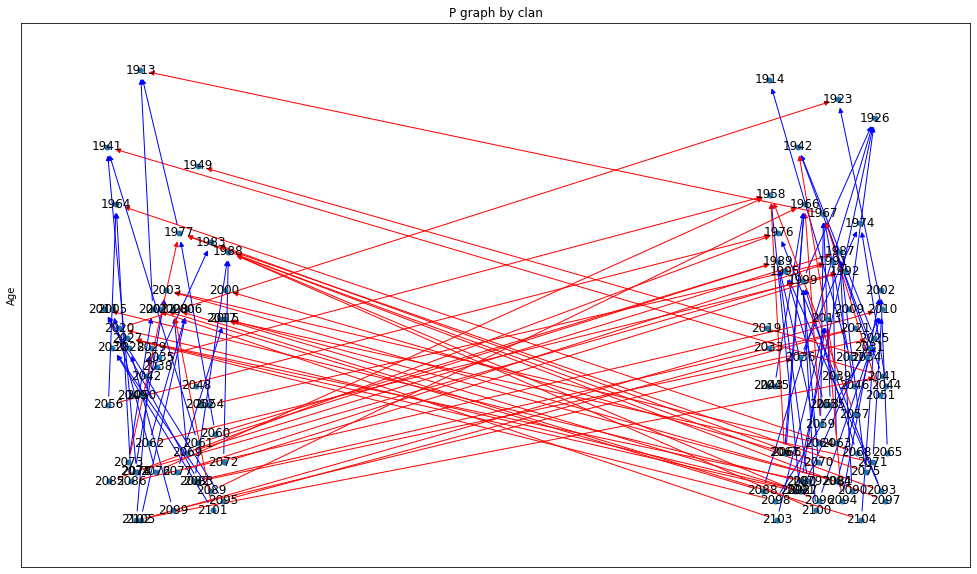

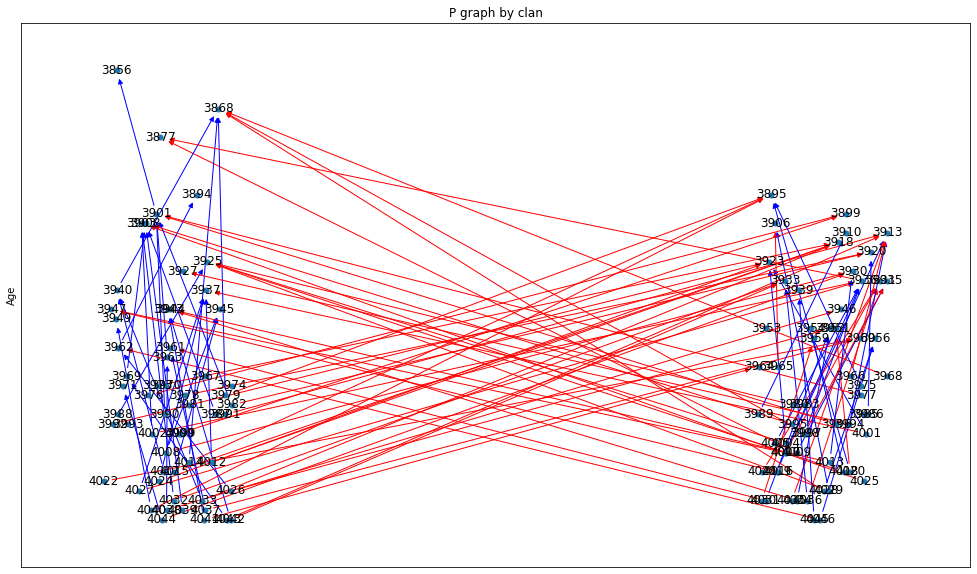

3


KeyboardInterrupt: 

In [4]:
#DUAL ORGANIZATION CONTROL POPULATION
#Parameters dual_organization
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
mediao = 4 # Average children per UD
t = 1000 #steps of the simulation
original_media = mediao
media = original_media
cycles = [[],[]]
final_pop = []
contador = 0
while contador < 100:
    #### Initialization dual_organization
    ## Clans
    clanes = [1,2]
    clans = (clanes * (iniciais // 2)) + clanes[:(iniciais % 2)]
    random.shuffle(clans)
    UD_dual_organization.uds = {}
    instancias_ud = []
    for id_ud in range(1, int(iniciais) + 1):
            instancias_ud.append(UD_dual_organization(id_ud, media, clans.pop()))
    ## Varieties
    limited_varieties = True
    if limited_varieties == False:
        for id_ud, ud in UD_dual_organization.uds.items():
            for _ in range(3):
                ud.varieties.append(Variety())
    else:
        initial_varieties = [Variety() for _ in range (10)]
        for ud in UD_dual_organization.uds.values():
            for _ in range(3):
                ud.varieties.append(random.choice(initial_varieties))
    #### Simulation dual_organization
    vivas = [int(iniciais)]
    for i in range (1, (t+1)):
        uds_copy = {id_ud: ud for id_ud, ud in UD_dual_organization.uds.items() if ud.activa}
        # Convertir el diccionario en una lista de pares (clave, valor)
        items = list(uds_copy.items())
        random.shuffle(items)
        uds_copy = dict(items)
        alive = len(uds_copy)
        if alive > 200 and (media == original_media):
            media -= media//2
            if media >= 4:
                media = media //2
        elif alive < 150 and media < original_media:
            media = original_media
        if not uds_copy:
            print("acabo")
            break
        for id_ud, ud in uds_copy.items():
            ud.ter_filho()
            ud.buscar_ud(uds_copy, media, 50, True, 0.2)
            ud.incrementar_idade()
            ud.death_probability(prob_morte)
#         if i%500 ==0:
#             p_graph_attribute(uds_copy, 'clan', False, True)
    if uds_copy:
        contador += 1
        final_pop.append(len(uds_copy))
        full = p_graph_attribute(UD_dual_organization.uds, "clan", False)
        cs = detect_cycles(full, 'clan')
        cycles2 = cs['cycle_2'] * 100 / (cs['cycle_1'] + cs['cycle_2'])
        cycles[1].append(cycles2)
        cycles[0].append(100 - cycles2)
# Structure data into a dictionary
simulation_data = {
    "experiments": contador,
    "final_pop": final_pop,
    "cycles": cycles
}
folder_name = 'results_validation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Save to a JSON file
output_file = os.path.join(folder_name, "validation_dual_organizations.json")
with open(output_file, "w") as file:
    json.dump(simulation_data, file, indent=4)

print(f"Simulation results saved to {output_file}")

In [5]:
# Folder
folder_name = 'results_validation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
name = os.path.join(folder_name, "validation_dual_organizations.json")
with open(name, 'r') as json_file:
        loaded_val_dual = json.load(json_file)

# Generalized

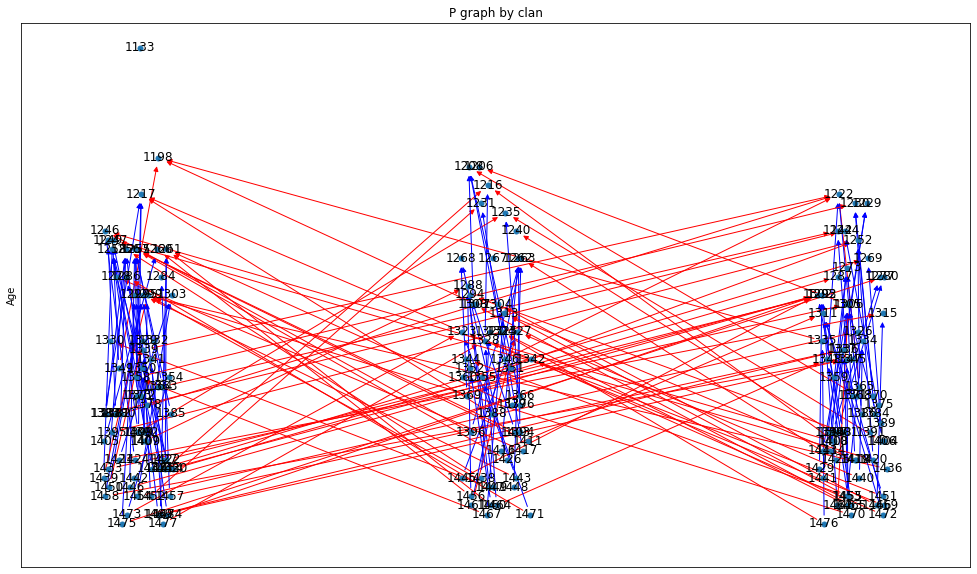

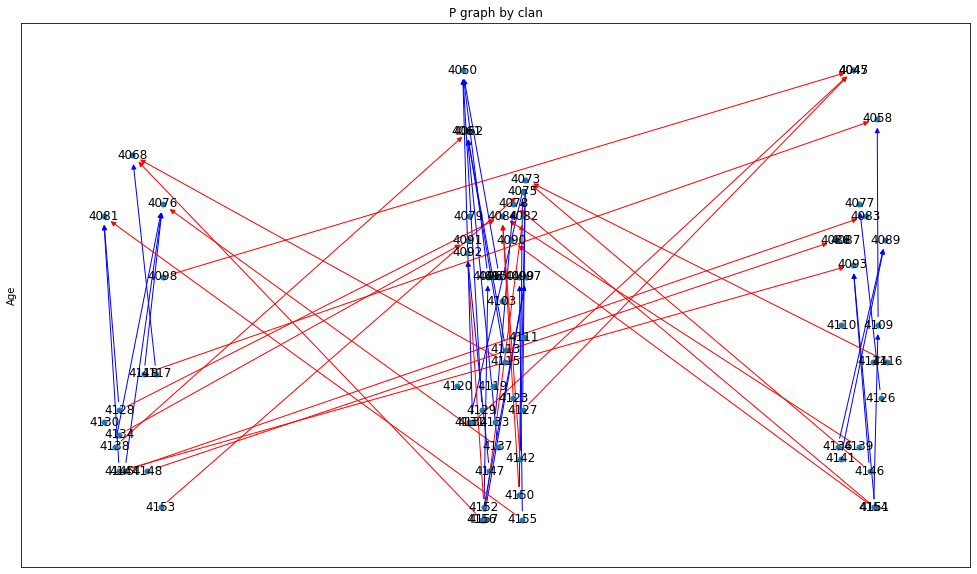

1
acabo
not enough clans
1


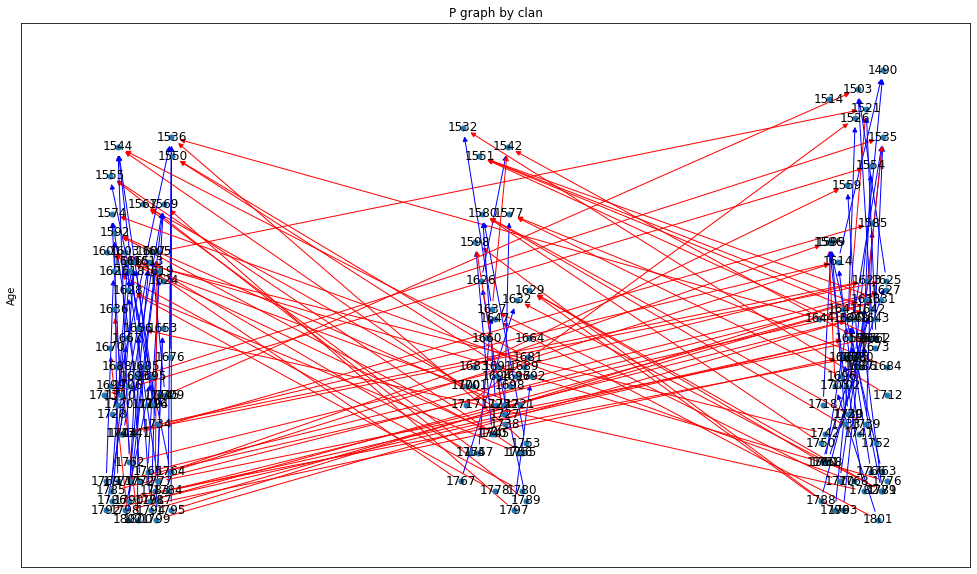

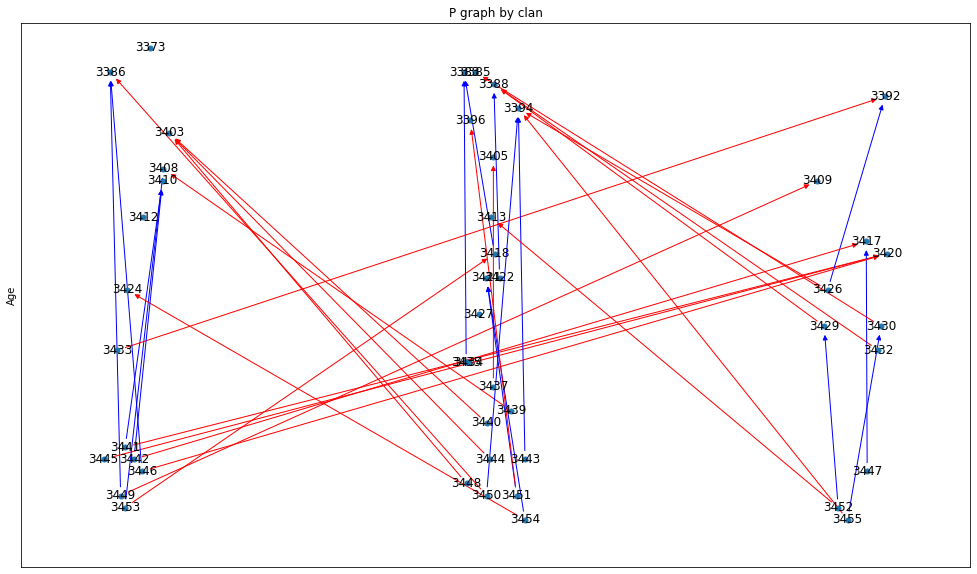

2
acabo
not enough clans
2
acabo
not enough clans
2


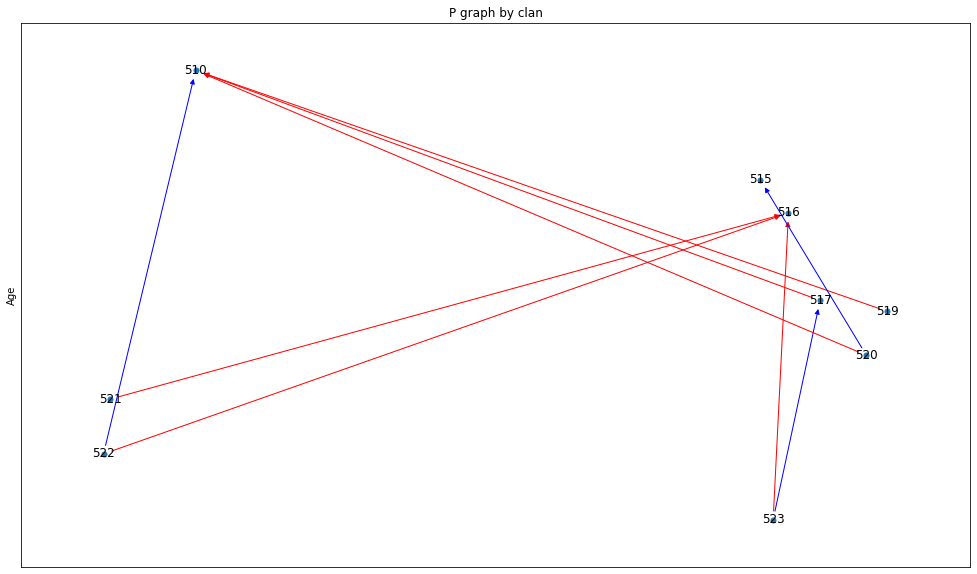

acabo
not enough clans
2


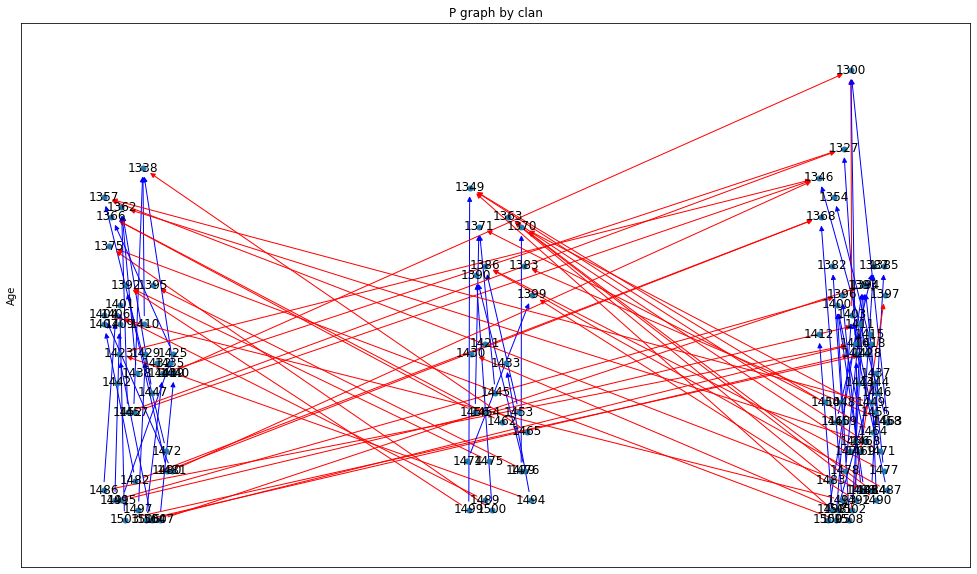

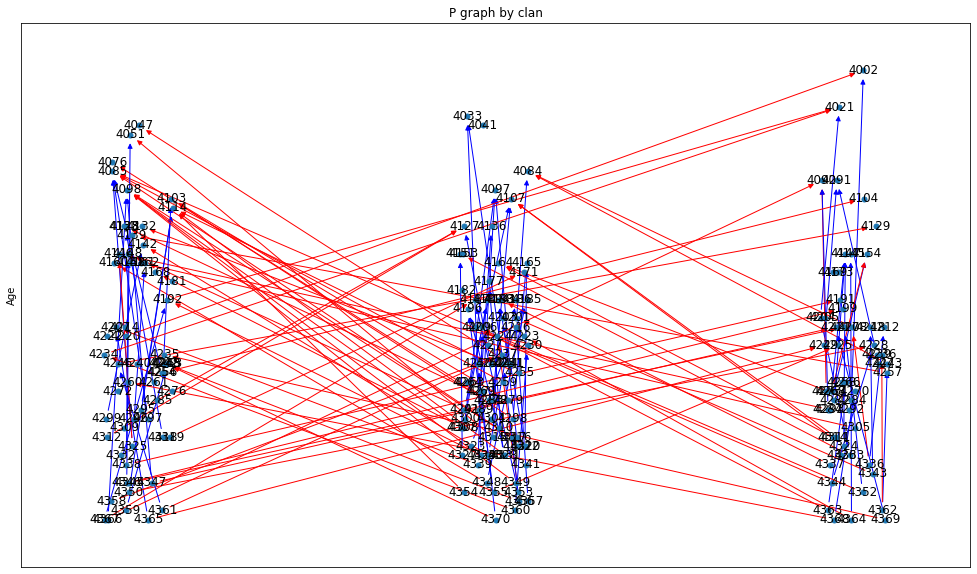

3
acabo
not enough clans
3
acabo
not enough clans
3
acabo
not enough clans
3


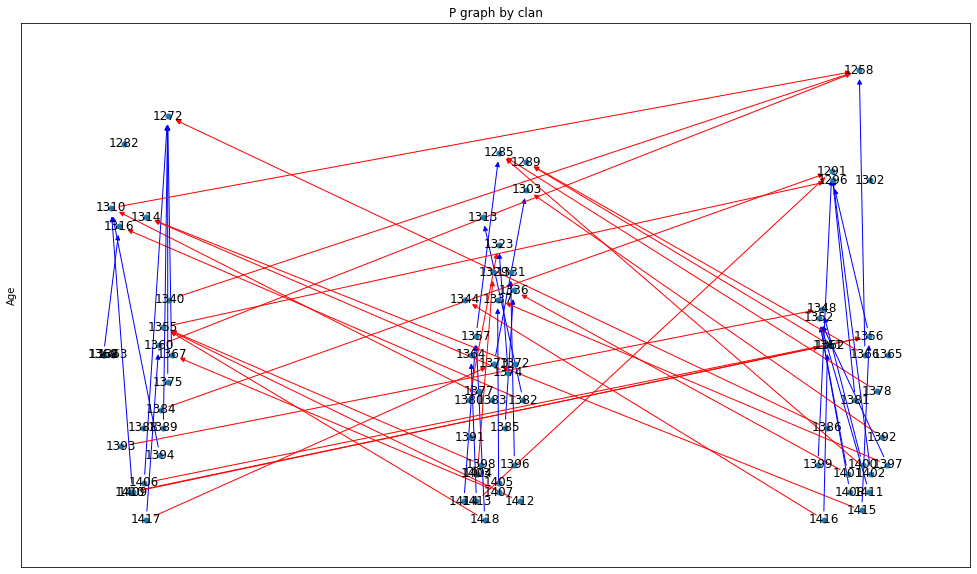

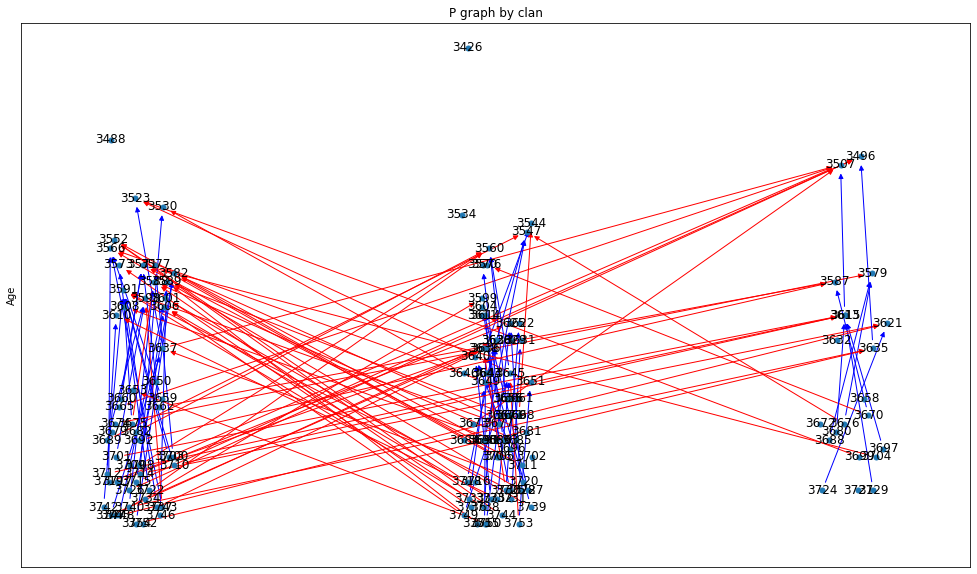

4


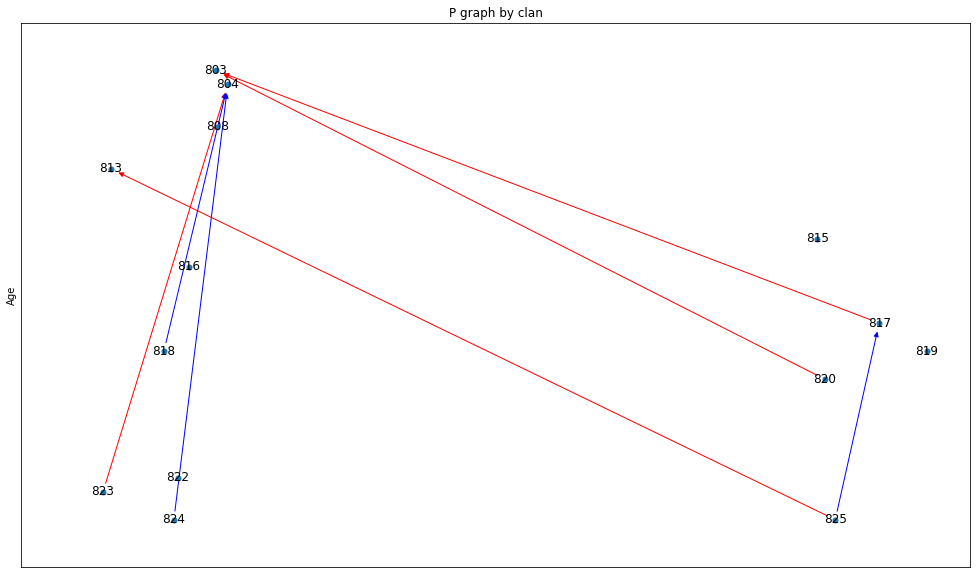

acabo
not enough clans
4


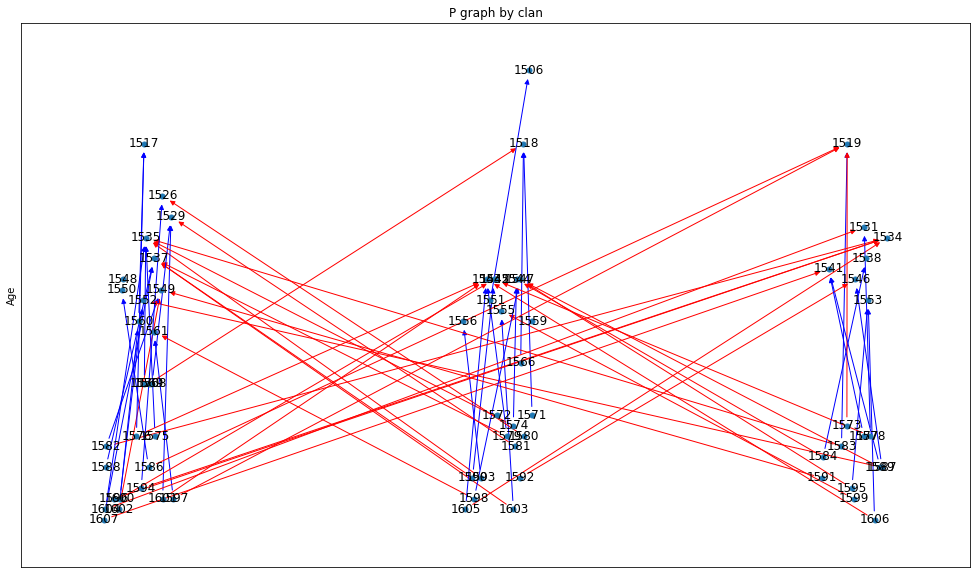

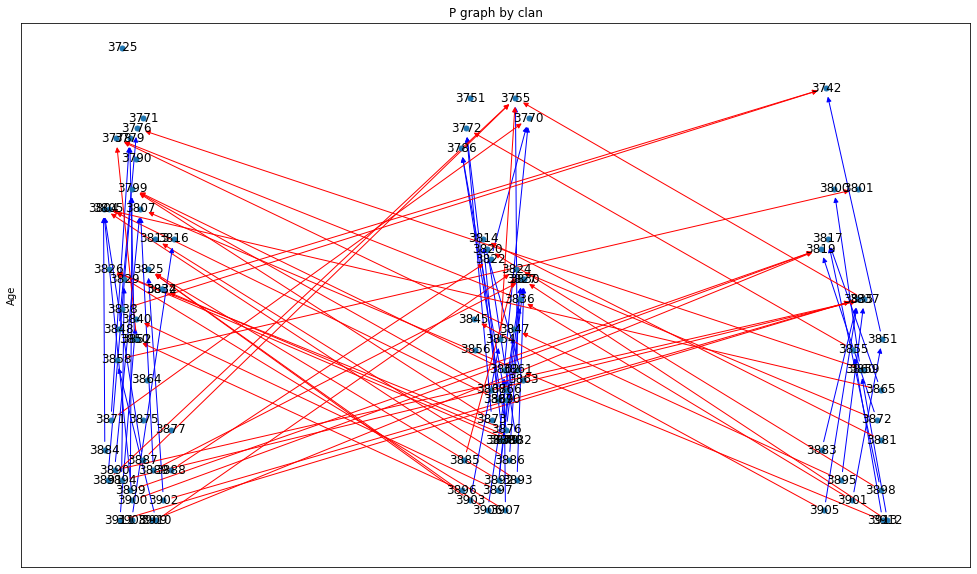

5


KeyboardInterrupt: 

In [6]:
#Generalized CONTROL POPULATION
#Parameters UD_generalized
iniciais = 40 # Initial UD

prob_morte = 0.06 # Beta from the gutertz equation
mediao = 4 # Average children per UD
random.seed(42) # Random seed
t = 1000 #steps of the simulation
dataset = [] #For the data
original_media = mediao
media = original_media
cycles=[[],[],[]]
final_pop = []
contador = 0
while contador < 100:
    clanes = [1,2,3]
    clans = (clanes * (iniciais // 3)) + clanes[:(iniciais % 3)]# Just 3 clans
    random.shuffle(clans)
    #### Initialization dual_organization
    ## Clans
    UD_generalized.uds = {}
    instancias_ud = []
    for id_ud in range(1, int(iniciais) + 1):
            instancias_ud.append(UD_generalized(id_ud, media, clans.pop()))
    ## Varieties
    limited_varieties = True
    if limited_varieties == False:
        for id_ud, ud in UD_generalized.uds.items():
            for _ in range(3):
                ud.varieties.append(Variety())
    else:
        initial_varieties = [Variety() for _ in range (10)]
        for ud in UD_generalized.uds.values():
            for _ in range(3):
                ud.varieties.append(random.choice(initial_varieties))
    #### Simulation dual_organization
    vivas = [int(iniciais)]
    for i in range (1, (t+1)):
        uds_copy = {id_ud: ud for id_ud, ud in UD_generalized.uds.items() if ud.activa}
        # Convertir el diccionario en una lista de pares (clave, valor)
        items = list(uds_copy.items())
        random.shuffle(items)
        uds_copy = dict(items)
        alive = len(uds_copy)
        if alive > 200 and (media == original_media): #or media == original_media-1):
            media -= media//2
            if media >= 4:
                media = media //2
        elif alive < 150 and media < original_media:
            media = original_media
        if not uds_copy:
            print("acabo")
            break
        for id_ud, ud in uds_copy.items():
            ud.ter_filho()
            ud.buscar_ud(uds_copy, media, 50, True, 0.2)
            ud.incrementar_idade()
            ud.death_probability(prob_morte)
#         if i%500 ==0:
#             p_graph_attribute(uds_copy, 'clan', False, True)
    if not any(UD.clan == 3 for id, UD in uds_copy.items()):
        print('not enough clans')
    if uds_copy and any(UD.clan == 3 for id, UD in uds_copy.items()):
        contador += 1
        final_pop.append(len(uds_copy))
        full = p_graph_attribute(UD_generalized.uds, "clan", False)
        cs = detect_cycles_three_generations(full, 'clan')
        total = (cs['cycle_1'] + cs['cycle_2']+ cs['cycle_3'])
        cycle3 = (cs['cycle_3'] * 100) / total
        cycle2 = (cs['cycle_2'] * 100) / total
        cycles[2].append(cycle3)
        cycles[1].append(cycle2)
        cycles[0].append(100 - (cycle2+cycle3))
# Structure data into a dictionary
simulation_data = {
    "experiments": contador,
    "final_pop": final_pop,
    "cycles": cycles
}
# Folder
folder_name = 'results_validation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Save to a JSON file
output_file = os.path.join(folder_name, "validation_generalized_exchange.json")
with open(output_file, "w") as file:
    json.dump(simulation_data, file, indent=4)

print(f"Simulation results saved to {output_file}")

In [7]:
# Folder
folder_name = 'results_validation'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
name = os.path.join(folder_name, "validation_generalized_exchange.json")
with open(name, 'r') as json_file:
        loaded_val_gen = json.load(json_file)

In [8]:
mean1g = np.mean(loaded_val_gen['cycles'][0])
std1g = np.std(loaded_val_gen['cycles'][0])
mean2g = np.mean(loaded_val_gen['cycles'][1])
std2g = np.std(loaded_val_gen['cycles'][1])
mean3g = np.mean(loaded_val_gen['cycles'][2])
std2g = np.std(loaded_val_gen['cycles'][2])
meanpopg = np.mean(loaded_val_gen['final_pop'])
mean1 = np.mean(loaded_val_dual['cycles'][0])
std1 = np.std(loaded_val_dual['cycles'][0])
mean2 = np.mean(loaded_val_dual['cycles'][1])
std2 = np.std(loaded_val_dual['cycles'][1])
meanpop = np.mean(loaded_val_dual['final_pop'])
print(f'''
Dual Organization
mean 1: {mean1} 
std 1: {std1}
mean 2: {mean2}
std 2: {std2}
''')
print(f'final pop {meanpop}')
print(f'''
Generalized exchange
mean 1 cycle = {mean1g}
std 1 cycle = {std1g}
mean 2 cycle = {mean2g}
std 2 cycle = {std1g}
mean 3 cycle = {mean3g}
std 3 cycle = {std1g}
mean pop = {meanpopg}
''')


Dual Organization
mean 1: 29.173517990475215 
std 1: 2.907158639655391
mean 2: 70.82648200952478
std 2: 2.907158639655391

final pop 122.4

Generalized exchange
mean 1 cycle = 12.003385263250362
std 1 cycle = 1.4347017255566255
mean 2 cycle = 33.563837923248165
std 2 cycle = 1.4347017255566255
mean 3 cycle = 54.43277681350147
std 3 cycle = 1.4347017255566255
mean pop = 111.94



In [13]:
dual = {
    '1 cycle': mean1, 
    '1 cycle std': std1, 
    '2 cycle': mean2, 
    '2 cycle std': std2, 
    'mean population': meanpop
}

gen = {
    '1 cycle': mean1g, 
    '1 cycle std': std1g, 
    '2 cycle': mean2g, 
    '2 cycle std': std2g, 
    '3 cycle': mean3g, 
    '3 cycle std': std2g, 
    'mean population': meanpopg
}

# Create the DataFrame
df = pd.DataFrame({'Dual Organization': dual, 'Generalized': gen}).T
#print(df)

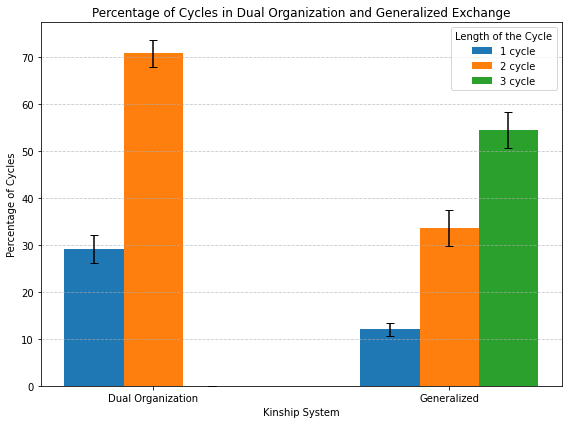

In [14]:
systems = ['Dual Organization', 'Generalized'] 
cycles = ['1 cycle', '2 cycle', '3 cycle'] # Cycle types for legend
means = df.loc[:, ['1 cycle', '2 cycle', '3 cycle']].fillna(0).to_numpy()  
errors = df.loc[:, ['1 cycle std', '2 cycle std', '3 cycle std']].fillna(0).to_numpy() 

x = np.arange(len(systems))  
width = 0.2  

#Plot
fig, ax = plt.subplots(figsize=(8, 6))
for i, cycle in enumerate(cycles):
    ax.bar(x + i * width - width, means[:, i], width, yerr=errors[:, i], 
           label=cycle, capsize=4, color=sns.color_palette("tab10")[i])

ax.set_title('Percentage of Cycles in Dual Organization and Generalized Exchange')
ax.set_xlabel('Kinship System')
ax.set_ylabel('Percentage of Cycles')
ax.set_xticks(x)
ax.set_xticklabels(systems) 
ax.legend(title='Length of the Cycle')  
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()